In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import scipy.stats
import tqdm


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


download CLIP

In [3]:
import open_clip
import clip
from open_clip import tokenizer

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


prepare a dataset

In [4]:
import tarfile
from torchvision.datasets.utils import download_url

dataset_url = "https://files.fast.ai/data/examples/cifar10.tgz"
download_url(dataset_url, '.')


with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./datasets')

Using downloaded and verified file: ./cifar10.tgz


In [5]:
import os

data_path = './datasets/cifar10'
print(os.listdir(data_path))

['train', 'test', 'labels.txt']


In [6]:
batch_size = 32
n_worker = 2

n_class = 10

traindir = data_path + "/train"

In [8]:
import random

seed_val = 123
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, preprocess),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True
)

#train_loader_wo_crops = torch.utils.data.DataLoader(
#    datasets.ImageFolder(traindir, preprocess),
#    batch_size=batch_size, shuffle=True,
#    num_workers=n_worker, pin_memory=True
#)

testdir = data_path + "/test"
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, preprocess),
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker, pin_memory=True
)

In [9]:
train_dataset = datasets.ImageFolder(traindir, preprocess)
test_dataset = datasets.ImageFolder(testdir, preprocess)

In [10]:
classes = {}
with open("./datasets/cifar10/labels.txt", "r") as f:
    cls_names = f.read().lower().split("\n")

for i, cls_name in enumerate(cls_names):
    classes[i] = cls_name

del classes[10]

In [11]:
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [18]:
# draws a batch of data
def draw_batch_of_data(batch_no: int, loader: torch.utils.data.dataloader.DataLoader):
    if batch_no >= len(loader):
        print("Batch number is out of range.")
        return
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == batch_no:
            plt.figure(figsize=(12, 6))
            for i in range(len(images)):
                plt.subplot(4, batch_size//4, i+1)
                image = images[i].numpy().transpose((1, 2, 0))
                image = (image - image.min()) / (image.max() - image.min())
                plt.imshow(image)
                plt.title(f"{classes[labels[i].item()]}")
                plt.axis('off')
            plt.show()
            break

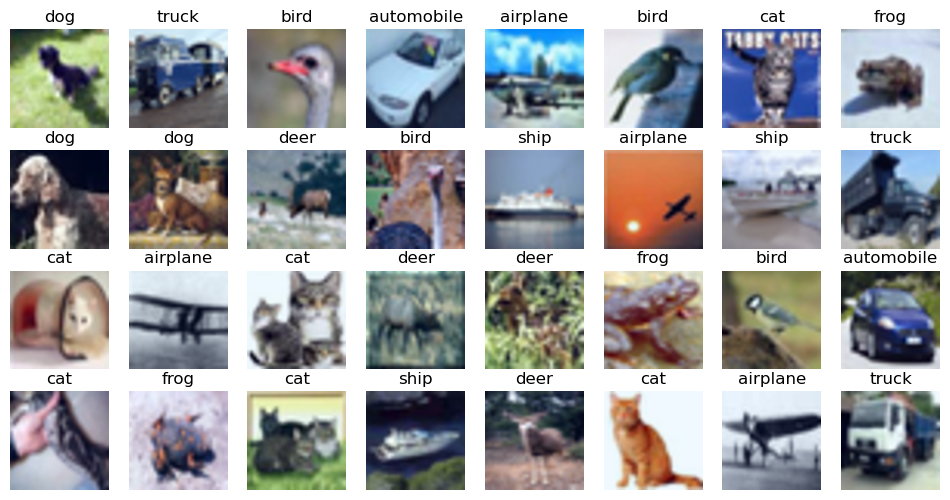

In [19]:
draw_batch_of_data(0, train_loader)

In [20]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

In [21]:
with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [22]:
def prepare_images_for_clip(loader: torch.utils.data.dataloader.DataLoader):
    clip_model.to(device)
    clip_model.eval()

    image_features = []

    for batch in loader:
        images, _ = batch
        images = images.to(device)

        with torch.no_grad():
            image_encoding = clip_model.encode_image(images).float()

        image_features.append(image_encoding)

    image_features = torch.cat(image_features, dim=0)

    return image_features

def prepare_concepts_for_clip(concepts: list, tbs=10):
    '''tbs is temporary batch size parameter'''
    clip_model.to(device)
    clip_model.eval()

    num_tbs = (len(concepts) + tbs - 1) // tbs 
    concept_features = []

    for idx in range(num_tbs):
        start = idx * tbs
        end = min((idx + 1) * tbs, len(concepts))

        batch_concepts = concepts[start:end]
        texts = clip.tokenize(batch_concepts).to(device)

        with torch.no_grad():
            concept_encoding = clip_model.encode_text(texts).float()

        concept_features.append(concept_encoding)

    concept_features = torch.cat(concept_features, dim=0)

    return concept_features

def get_concepts_probs(image_features, concept_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    concept_features /= concept_features.norm(dim=-1, keepdim=True)
    
    # get concept probs according to CLIP
    concept_probs = (100.0 * image_features @ concept_features.T).softmax(dim=-1)
    # select top 5 conceps for visualization 
    top_probs, top_concepts = concept_probs.topk(5, dim=-1)
    return concept_probs, top_probs, top_concepts

def visualize_bottleneck(batch_no: int, loader: torch.utils.data.dataloader.DataLoader,
                         image_features, concept_probs, top_probs, 
                         top_concepts, concepts):
    if batch_no >= len(loader):
        print("Batch number is out of range.")
        return
    
    original_images = []
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == batch_no:
            original_images = images
            break

    plt.figure(figsize=(16, 16))
    for i in range(len(original_images)):
        plt.subplot(4, 4, min(2 * i + 1, len(original_images) // 2))
        image = original_images[i].numpy().transpose((1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(4, 4, min(2 * i + 2, len(original_images) // 2))
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs[i].cpu())
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [concepts[index] for index in top_concepts[i].cpu().numpy()])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [23]:
# computing image and descriptions features

image_features = prepare_images_for_clip(train_loader)

concept_features = prepare_concepts_for_clip(concepts)

In [24]:
concept_probs, top_probs, top_concepts = get_concepts_probs(image_features, concept_features)

In [25]:
print(top_probs[:10], "\n")
print(top_concepts[:10])

tensor([[0.1733, 0.1367, 0.0671, 0.0381, 0.0380],
        [0.5117, 0.2830, 0.0344, 0.0248, 0.0236],
        [0.1718, 0.1000, 0.0503, 0.0445, 0.0349],
        [0.0782, 0.0622, 0.0415, 0.0403, 0.0359],
        [0.1466, 0.1427, 0.0601, 0.0528, 0.0470],
        [0.2900, 0.1685, 0.1083, 0.0768, 0.0251],
        [0.1138, 0.0779, 0.0576, 0.0481, 0.0455],
        [0.4254, 0.0878, 0.0449, 0.0313, 0.0262],
        [0.0701, 0.0696, 0.0680, 0.0528, 0.0521],
        [0.5936, 0.1020, 0.0532, 0.0508, 0.0377]], device='cuda:0') 

tensor([[ 92,  55,  27,   6, 117],
        [ 92,  71,  68,  42,  70],
        [117,  92,  59,  42,  82],
        [111, 106,  94,  55,  76],
        [ 55, 111,  27, 103,   6],
        [ 21, 111, 110,  55, 106],
        [ 92,  96,  42, 103,  59],
        [ 92,  23,  55,  68, 107],
        [ 40,  92,  59,  42, 117],
        [ 92,  71,  55,  42,  68]], device='cuda:0')


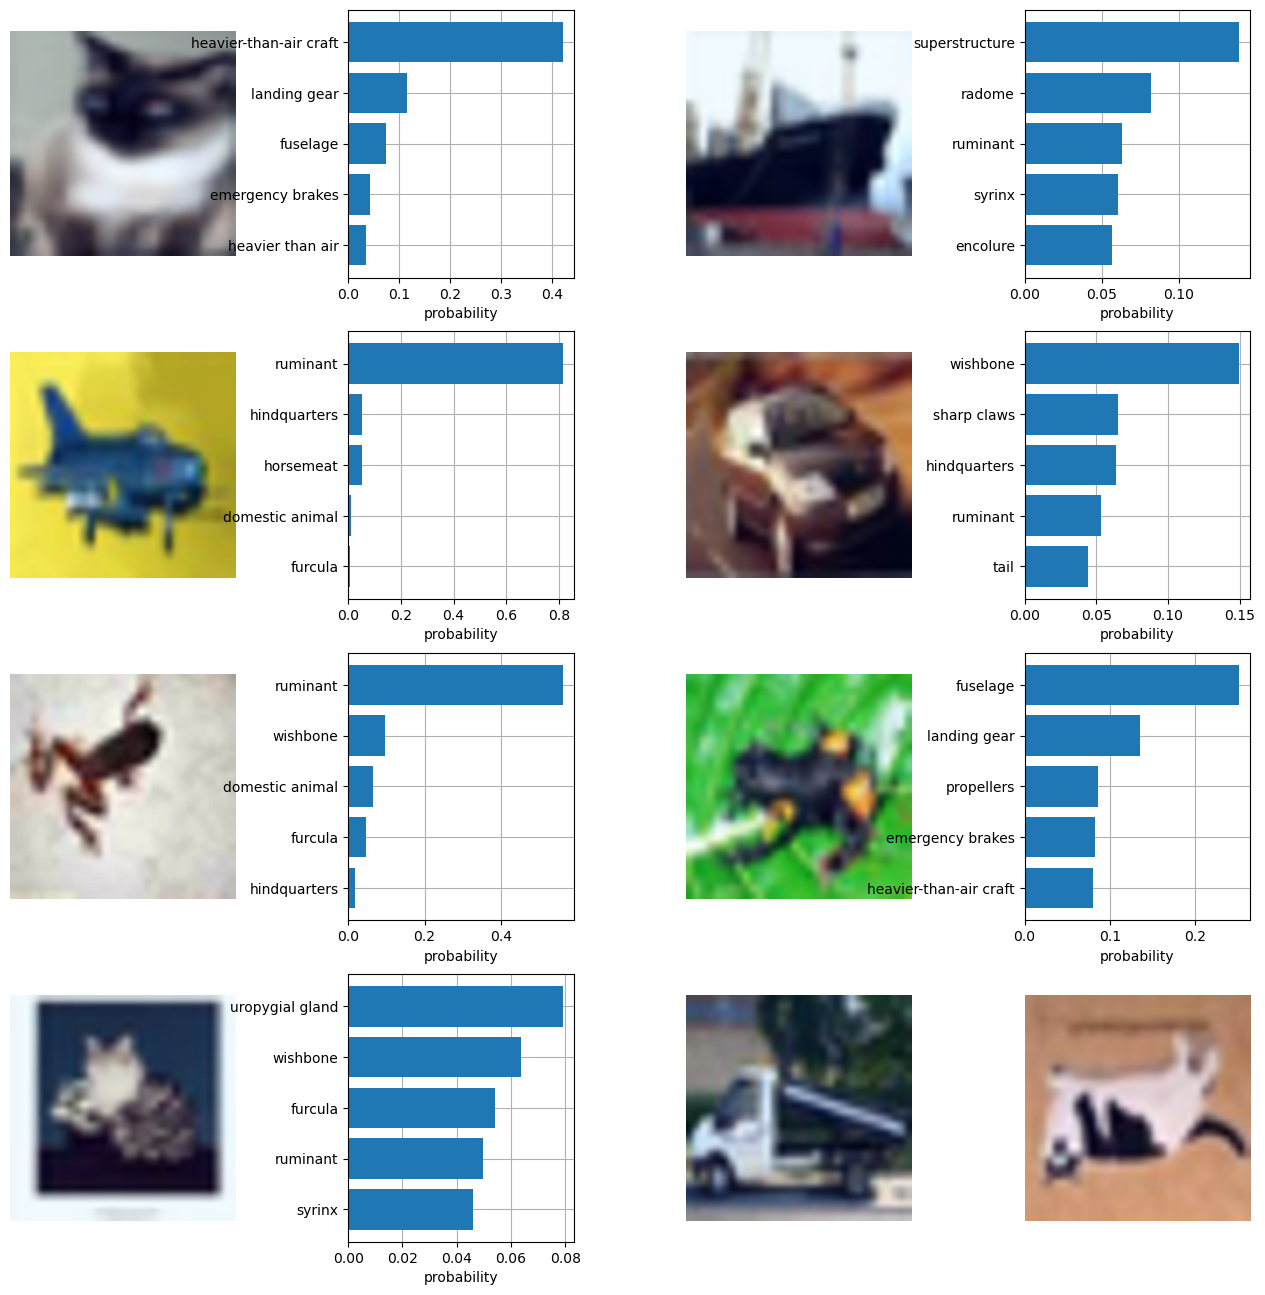

In [137]:
visualize_bottleneck(batch_no=0, 
                     loader=train_loader,
                     image_features=image_features, 
                     concept_probs=concept_probs, 
                     top_probs=top_probs, 
                     top_concepts=top_concepts, 
                     concepts=concepts)

In [17]:
# энкод картинок
# энкод текста
# получить пробы
# нарисовать
def prepare_images_for_clip_test(loader):
        clip_model.to(device)
        clip_model.eval()
        image_features = []
        for batch_idx, (images, labels) in enumerate(loader):
                images = images.to(device)
                
                with torch.no_grad():
                        image_encoding = clip_model.encode_image(images).float()
                        
                image_features.append(image_encoding)

        image_features = torch.cat(image_features, dim=0)

        return image_features, labels #!!!

image_features, labels = prepare_images_for_clip_test(train_loader)
concept_features = prepare_concepts_for_clip(concepts)
concept_probs, top_probs, top_concepts = get_concepts_probs(image_features, concept_features)

print(top_probs[:10], "\n")
print(top_concepts[:10])

tensor([[0.3325, 0.0579, 0.0578, 0.0479, 0.0358],
        [0.0977, 0.0977, 0.0586, 0.0552, 0.0414],
        [0.4082, 0.2852, 0.0617, 0.0410, 0.0159],
        [0.0921, 0.0812, 0.0774, 0.0752, 0.0613],
        [0.1640, 0.1192, 0.1177, 0.0416, 0.0394],
        [0.1746, 0.0689, 0.0580, 0.0377, 0.0366],
        [0.2077, 0.1024, 0.0703, 0.0676, 0.0457],
        [0.0894, 0.0703, 0.0620, 0.0438, 0.0368],
        [0.3335, 0.0947, 0.0857, 0.0631, 0.0235],
        [0.1987, 0.1659, 0.1446, 0.0664, 0.0470]], device='cuda:0') 

tensor([[117,  59,  42,  92,  40],
        [114,  16,  36, 100,  17],
        [ 55,  27, 111,  92,  59],
        [ 17,  16,   3,  40,  91],
        [ 56,  66,  87,  33,  36],
        [ 27, 111, 106,  42,  31],
        [ 96,  68, 106,  90,  59],
        [ 74,  33,  92, 111,  25],
        [ 92, 117,  42,  55,  40],
        [ 92, 117,  42, 103,  68]], device='cuda:0')


In [32]:
with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        image_features = clip_model.encode_image(images)
        text_inputs = clip.tokenize([c for c in concepts]).to(device)
        text_features = clip_model.encode_text(text_inputs)
        concept_probs[i * batch_size: (i + 1) * batch_size] = (100.0 * image_features @ text_features.t()).softmax(dim=-1)

In [35]:
classifier = nn.Linear(len(concepts), 10)  # 10 классов в CIFAR-10
classifier.to(device)


labels = torch.arange(10).to(device)
one_hot_labels = torch.eye(10).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

for epoch in range(10):  
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        logits = classifier(concept_probs[i * batch_size: (i + 1) * batch_size])
        loss = criterion(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}: Loss={loss.item()}")

Epoch 1: Loss=2.2881381511688232
Epoch 2: Loss=2.3174774646759033
Epoch 3: Loss=2.293041467666626
Epoch 4: Loss=2.305654764175415
Epoch 5: Loss=2.313045024871826
Epoch 6: Loss=2.2872161865234375
Epoch 7: Loss=2.302847146987915
Epoch 8: Loss=2.297630786895752
Epoch 9: Loss=2.2844059467315674
Epoch 10: Loss=2.2993011474609375


Classifier model

In [ ]:
'''as input i want to take pair (cls, concept) and do cls as one-hot
ALSO i do not want to sort concepts by probability, only use a vector
of shape [num_concepts * 1] where at the every position will stay 
a probability of corresponding concept in a given image'''

class ByConceptsClassifier(nn.Module):
    def __init__(self, embedding_dim, concepts_size, images_size, num_classes):
        super(ByConceptsClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.concepts_size = concepts_size
        self.images_size=images_size
        self.num_classes = num_classes

        self.linear1 = nn.Linear(concepts_size, embedding_dim)
        self.gelu = nn.GELU()
        #self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        # x = self.relu(x)
        x = self.linear2(x)
        return x

# embedding_dim = 512
# concepts_size = 174 
# num_classes = 10